In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (46.1.3)


In [4]:
#from rainbow import *
import gym
from gym.wrappers import Monitor
from gym import logger as gymlogger
gymlogger.set_level(40)  # error only
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import cv2
display = Display(visible=0, size=(1400, 900))
display.start()


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env


def save_animation(frames, path, fs=30):
    size = frames[0].shape[1], frames[0].shape[0]
    out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'MP4V'), fs, size)
    for i in range(len(frames)):
        out.write(frames[i])
    out.release()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [8]:
# Select an environment
env_name = ["CartPole-v0", "MsPacman-v0"]

# PARAMETERS----------------------------------------------------
env_idx = 0  # environment id
num_frames = 20000  # number of training frames
memory_size = 2000  # replay memory size
batch_size = 32  # batch size
target_update = 1000  # update target network frequency
frame_interval = 1000  # refresh plot frequency
plot = True  # plot score and loss during training
model_name = env_name[env_idx] + "_" + str(num_frames)  # model name, don't need to change it
training_delay = num_frames // 50  # number of frames before start training
trials = 10  # number of evaluation episodes
frames_stack = 1  # number of consecutive frames to take as input
train = True  # train a new model
test = True  # evaluate the new model if train==True,
             # otherwise try to load an old model that has been trained for num_frames frames
             # and if present use it to perform evaluation
# ---------------------------------------------------------------

preprocess_function = None 
if env_idx == 1:  # MsPacman: convert to greyscale, resize, crop and normalize each frame
    preprocess_function = preprocess_obs_pacman

env = wrap_env(gym.make(env_name[env_idx]))

agent = DQNAgent(env, memory_size, batch_size, target_update,
                 plot=plot,
                 frame_interval=frame_interval,
                 frame_preprocess=preprocess_function,
                 n_frames_stack=frames_stack,
                 model_name=model_name,
                 training_delay=training_delay,
                 )

Using DenseNet
Device cuda


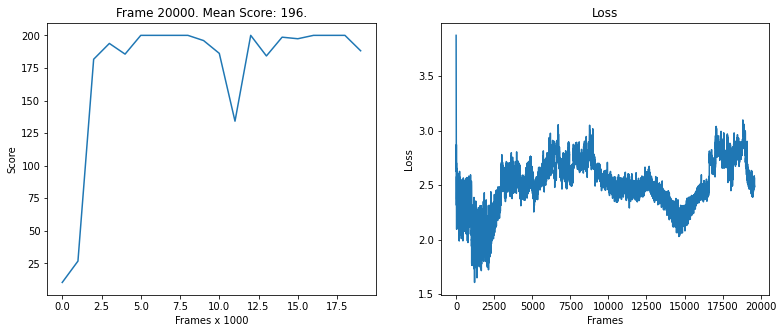

Saving model...
Model saved in: models/CartPole-v0_20000.tar
Restoring saved model...
Model restored from: models/CartPole-v0_20000.tar
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Score:  200.0
Average score: 200.0
Best score: 200.0
Video saved at videos/CartPole-v0_20000.mp4


In [9]:
if train:
    score, loss = agent.train(num_frames)
    agent.save()

if test:
    best_score = -np.inf
    best_frames = []
    agent.load()
    tot_score = 0
    frames = []
    for i in range(trials):
        score, frames = agent.test(get_frames=True)
        tot_score += score
        print("Score: ", score)
        if score > best_score:
            best_score = score
            best_frames = frames
    print("Average score:", tot_score / trials)
    print("Best score:", best_score)

    env.close()

    if not os.path.exists("videos"):
        os.makedirs("videos")
    save_path = os.path.join("videos", model_name + ".mp4")
    save_animation(best_frames, save_path, 20)
    print("Video saved at", save_path)